# Packet Capture Statistical Analysis

## Preamble

This is where we get the data ready to work.

In [25]:
# Import dependencies
import pandas as pd
from scapy.all import *
import plotly.express as px
import networkx as nx
import plotly.graph_objects as go

In [58]:
# PCAP File: CHANGE FOR DIFFERENT RUNS
PCAP_FILE = "pcaps/mta1.pcap"

In [59]:
# Read in PCAP data
pc = rdpcap(PCAP_FILE)

In [60]:
def extract_fields(packet):
    """
    Flattens Packet objects into usable dicts
    """
    res = {}
    layers = packet.layers()
    for i in range(len(layers)):
        layer = packet.getlayer(i)
        res.update(layer.fields)
    return res

In [61]:
packets = list(map(extract_fields, pc))

In [62]:
df = pd.DataFrame(packets)

## Exploratory Data Analysis

Here, we get a feel for the shape of the data

In [94]:
# Top 10 most trafficked desinations
df.groupby("dst").sum().sort_values(by="len", ascending=False).reset_index()[["dst","len"]].head(10)

,dst,len
0,172.16.165.165,2395469.0
1,37.200.69.143,22347.0
2,82.150.140.30,13633.0
3,74.125.233.96,11166.0
4,204.79.197.200,3059.0
5,188.225.73.100,2765.0
6,172.16.165.2,2007.0
7,ff02::1:2,1100.0
8,74.125.233.100,1095.0
9,131.253.61.84,877.0


### Network Graph

Simple visualization of connections in this capture. This reveals talkative sources, usually internal.

In [104]:
# Generate nodes/edges
nodes = pd.concat([df.src, df.dst]).drop_duplicates()
edges = df.groupby(["src","dst"]).sum().reset_index().apply(lambda p: (p.src, p.dst, {"weight": p.len * -1}), axis="columns")
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
layout = nx.spring_layout(G)

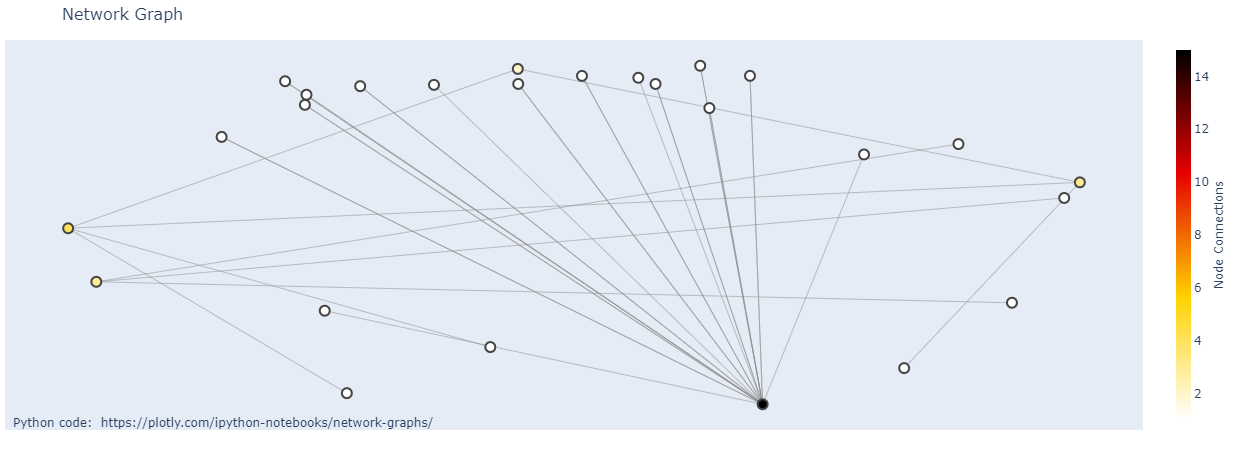

In [105]:
# Create X/Y coords for edges
edge_x = []
edge_y = []
for e in edges:
    node0 = e[0]
    node1 = e[1]
    x0, y0 = layout[node0][0], layout[node0][1]
    x1, y1 = layout[node1][0], layout[node1][1]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
# Create X/Y coords for nodes (much easier!)
node_x = [layout[l][0] for l in layout]
node_y = [layout[l][1] for l in layout]

# Create Edge Traces

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create Node Traces
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hovertext = list(layout.keys()),
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Hot',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

# Color Nodes
node_adjacencies = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

# Create Figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Network Graph',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [67]:
top_talkers = df.groupby("dst").sum().reset_index().sort_values(by="len", ascending=False).head()
top_ports = df.groupby("sport").sum().reset_index().sort_values(by="len", ascending=False).head()

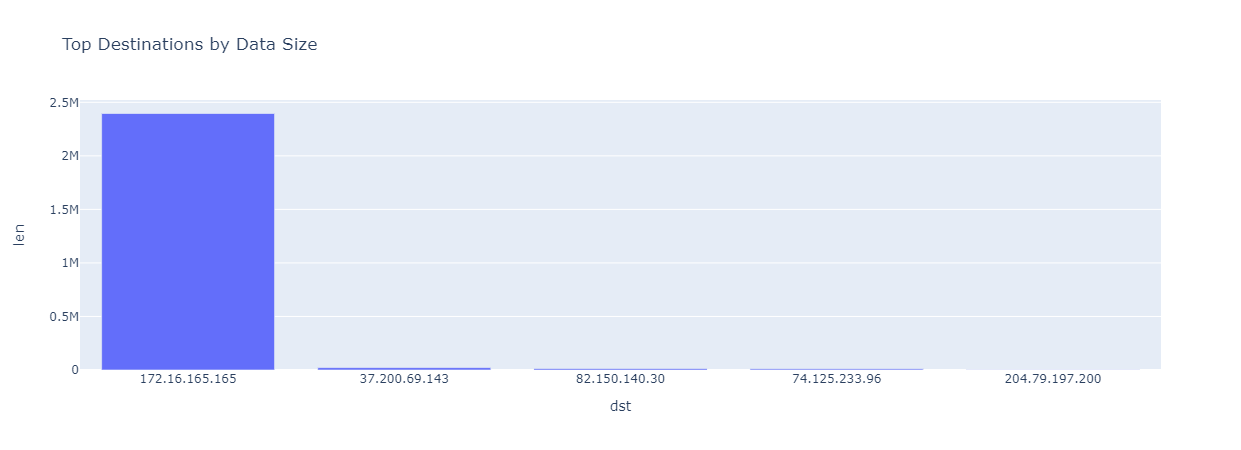

In [68]:
fig = px.bar(top_talkers, x="dst", y="len", title="Top Destinations by Data Size")
fig.show()

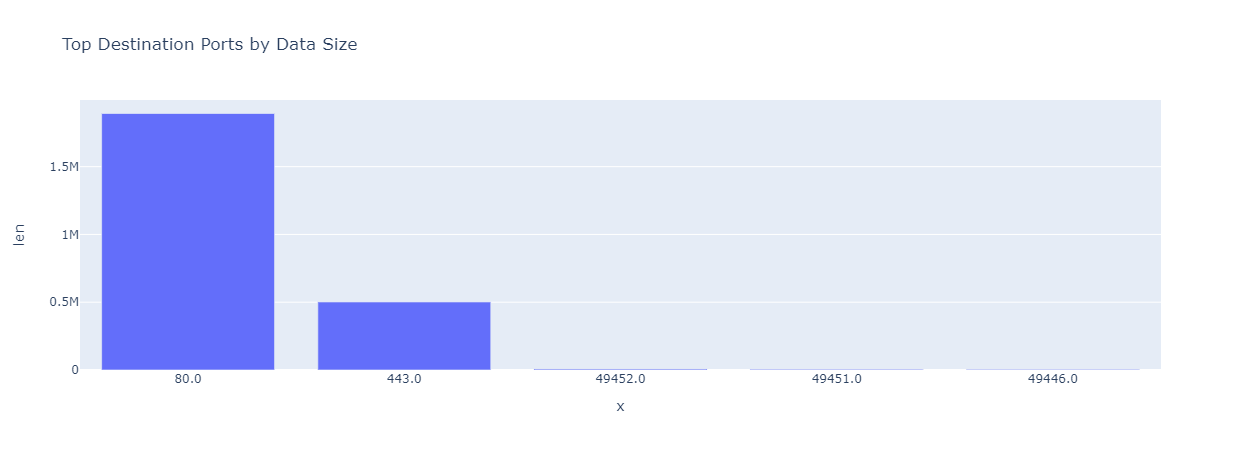

In [69]:
fig = px.bar(top_ports, x=top_ports.sport.astype(str), y="len", title="Top Destination Ports by Data Size")
fig.show()

In [70]:
df.groupby("sport").sum().sort_values(by="len", ascending=False)

,type,version,ihl,tos,len,id,frag,ttl,proto,chksum,...,xid,secs,c,autopad,otype,value,copy_flag,optclass,option,alert
sport,,,,,,,,,,,,,,,,,,,,,
80.0,3581952,6996.0,8745.0,0.0,1891993.0,2847786.0,0.0,223872.0,10494.0,49702372.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
443.0,823296,1608.0,2010.0,0.0,502080.0,524022.0,0.0,51456.0,2412.0,12449772.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49452.0,301056,588.0,735.0,0.0,7576.0,824534.0,0.0,18816.0,882.0,5098031.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49451.0,231424,452.0,565.0,0.0,6217.0,641579.0,0.0,14464.0,678.0,3185166.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49446.0,235520,460.0,575.0,0.0,5692.0,622406.0,0.0,14720.0,690.0,3700692.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49456.0,270336,528.0,660.0,0.0,5589.0,777634.0,0.0,16896.0,792.0,4199300.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49439.0,92160,180.0,225.0,0.0,3397.0,237047.0,0.0,5760.0,270.0,1518154.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49437.0,61440,120.0,150.0,0.0,2547.0,157093.0,0.0,3840.0,180.0,811014.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49442.0,34816,68.0,85.0,0.0,2279.0,90252.0,0.0,2176.0,102.0,389447.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## HTTP Analysis

In [71]:
http = df.query("dport == 80 | dport == 443 | sport == 80 | sport == 443").dropna(axis="columns", how="all")

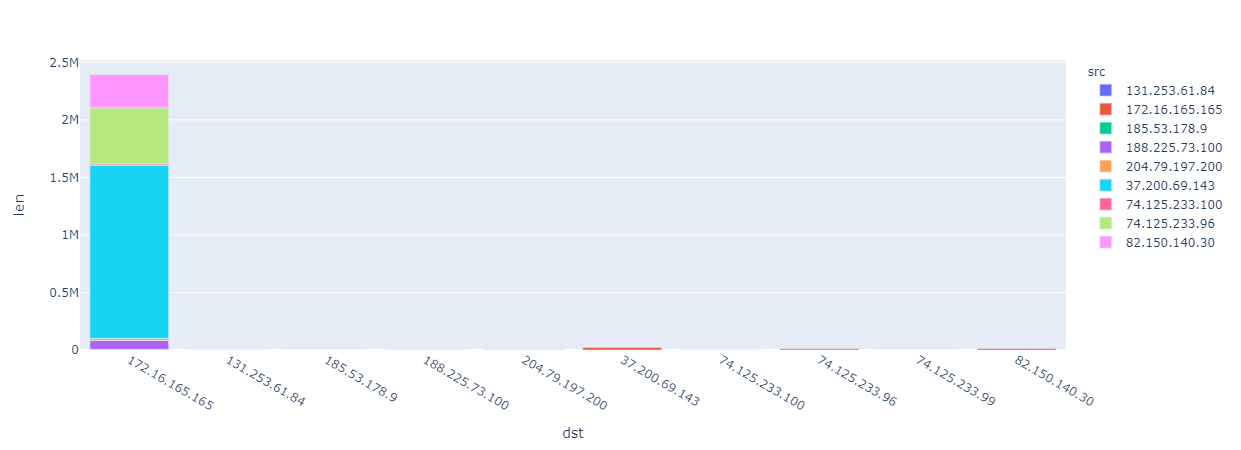

In [72]:
fig = px.bar(http.groupby(["src","dst"]).sum().reset_index(), x="dst", y="len", color="src")
fig.show()


In [73]:
http.groupby(["src","dst"]).sum().reset_index()

,src,dst,type,version,ihl,tos,len,id,frag,ttl,proto,chksum,sport,dport,seq,ack,dataofs,reserved,window,urgptr
0,131.253.61.84,172.16.165.165,8192,16.0,20.0,0.0,784.0,2024.0,0.0,512.0,24.0,213375.0,1772.0,197740.0,6.911574e+07,5.542018e+09,20.0,0.0,256959.0,0.0
1,172.16.165.165,131.253.61.84,6144,12.0,15.0,0.0,877.0,15444.0,0.0,384.0,18.0,130265.0,148305.0,1329.0,4.156513e+09,5.183756e+07,15.0,0.0,189313.0,0.0
2,172.16.165.165,185.53.178.9,16384,32.0,40.0,0.0,685.0,42341.0,0.0,1024.0,48.0,160259.0,395544.0,640.0,2.628468e+10,6.814320e+09,43.0,0.0,393622.0,0.0
3,172.16.165.165,188.225.73.100,67584,132.0,165.0,0.0,2765.0,179899.0,0.0,4224.0,198.0,1190830.0,1631844.0,2640.0,2.688085e+10,1.043549e+11,171.0,0.0,1869738.0,0.0
4,172.16.165.165,204.79.197.200,20480,40.0,50.0,0.0,3059.0,51557.0,0.0,1280.0,60.0,360755.0,494331.0,2615.0,2.046603e+10,2.174626e+10,53.0,0.0,517349.0,0.0
5,172.16.165.165,37.200.69.143,858112,1676.0,2095.0,0.0,22347.0,2400739.0,0.0,53632.0,2514.0,13493046.0,20720885.0,33520.0,1.362378e+12,1.376043e+12,2113.0,0.0,25412047.0,0.0
6,172.16.165.165,74.125.233.100,22528,44.0,55.0,0.0,1095.0,59781.0,0.0,1408.0,66.0,442654.0,543903.0,4510.0,3.894212e+10,1.674661e+10,58.0,0.0,520698.0,0.0
7,172.16.165.165,74.125.233.96,354304,692.0,865.0,0.0,11166.0,938218.0,0.0,22144.0,1038.0,5753542.0,8554283.0,74824.0,5.672431e+11,2.096014e+11,880.0,0.0,10484382.0,0.0
8,172.16.165.165,74.125.233.99,6144,12.0,15.0,0.0,120.0,17037.0,0.0,384.0,18.0,112631.0,148278.0,1329.0,3.704837e+09,3.145700e+09,15.0,0.0,0.0,0.0
9,172.16.165.165,82.150.140.30,286720,560.0,700.0,0.0,13633.0,740206.0,0.0,17920.0,840.0,4407616.0,6921471.0,11200.0,2.498784e+11,3.129670e+11,718.0,0.0,8228544.0,0.0


## DNS Analysis

In [74]:
dns_queries = df.query("dport == 53").dropna(axis="columns", how="all")

In [75]:
# Get Query Names
dns_queries["query_name"] = dns_queries.qd.apply(lambda q: q.qname.decode())
dns_count = dns_queries.groupby("query_name").count()

In [76]:
# Get standard deviation
dns_sigma = dns_count.std()["len"]

In [77]:
# Look for queries > 1.5 sigmas
high_dns = dns_count.query(f"len >= {dns_sigma}")

In [78]:
# Significant DNS queries
high_dns.sort_values(by="len", ascending=False).head()

,dst,src,type,options,version,ihl,tos,len,id,flags,...,ra,z,ad,cd,rcode,qdcount,ancount,nscount,arcount,qd
query_name,,,,,,,,,,,,,,,,,,,,,
stand.trustandprobaterealty.com.,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
24corp-shop.com.,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
adultbiz.in.,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
i.ytimg.com.,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
java.com.,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


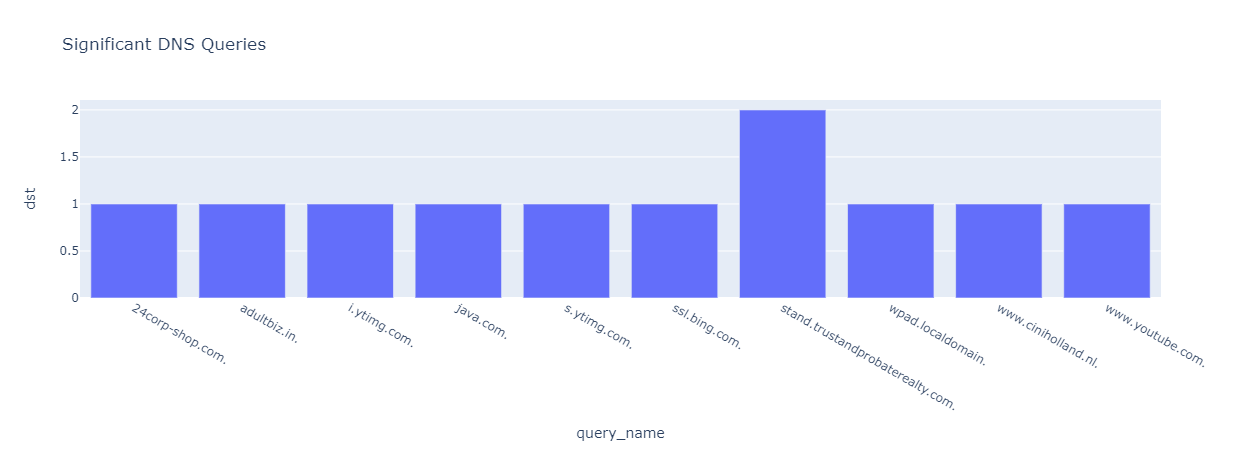

In [79]:
fig = px.bar(high_dns.reset_index(), x="query_name", y="dst", title="Significant DNS Queries")
fig.show()

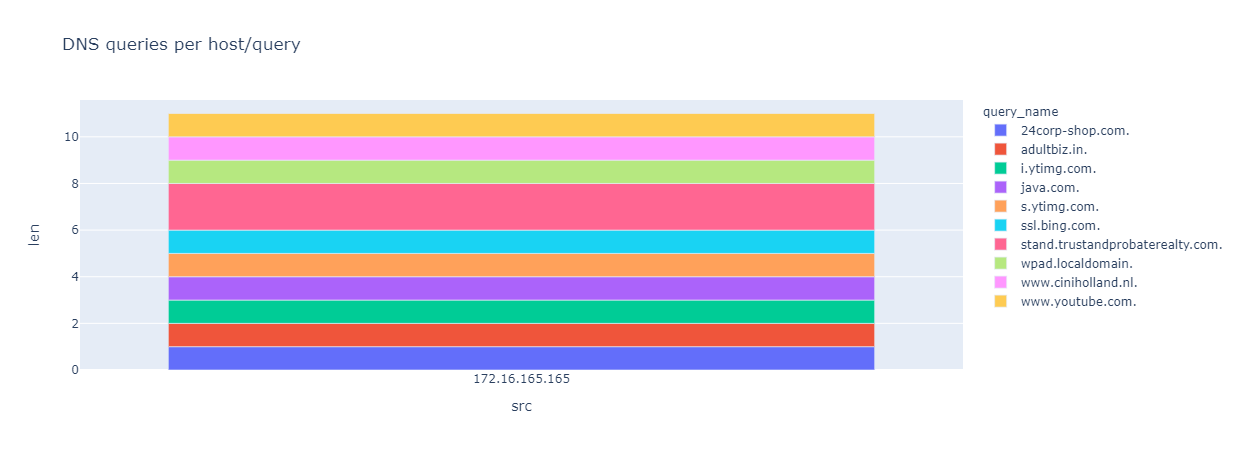

In [80]:
queries_by_host = dns_queries.groupby(["src", "query_name"]).count().query(f"len >= {dns_sigma}").reset_index()
fig = px.bar(queries_by_host, x="src", y="len", color="query_name", title="DNS queries per host/query")
fig.show()